## Importing Libraries

In [108]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import warnings
warnings.filterwarnings('ignore')

## Reading the data

In [109]:
data = pd.read_csv("airline-passenger-traffic.csv", header = None)
data.head()

,0,1
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [110]:
data.shape

(144, 2)

In [111]:
data.columns = ["Month", "Passengers"]
data["Month"] = pd.to_datetime(data["Month"], format = '%Y-%m')
data = data.set_index('Month')
data.head()

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


<Axes: xlabel='Month'>

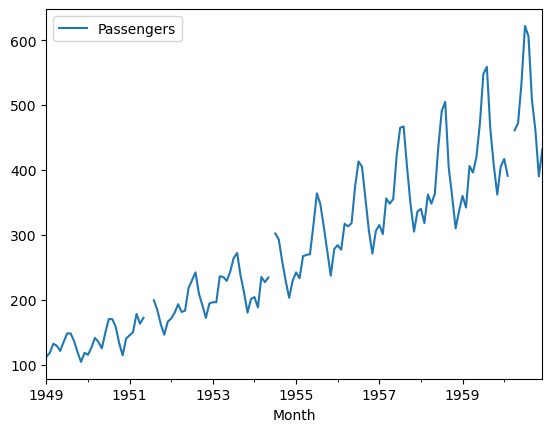

In [112]:
data.plot()

# Data Pre-processing

## Handling missing values

In [113]:
data[data.isnull().any(axis=1)]

,Passengers
Month,
1951-06-01,NaN
1951-07-01,NaN
1954-06-01,NaN
1960-03-01,NaN


### Mean Imputation

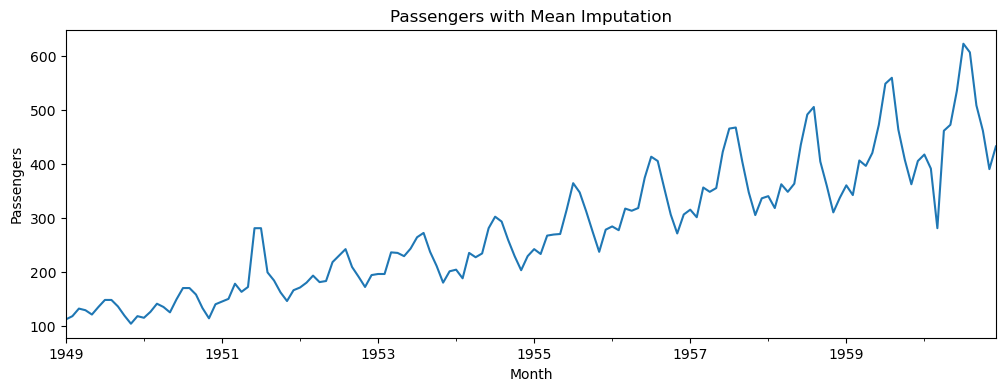

In [114]:
data["Passengers_Mean_imputation"] = data["Passengers"].fillna(data["Passengers"].mean())
data["Passengers_Mean_imputation"].plot(figsize=(12, 4))
plt.xlabel("Month")
plt.ylabel("Passengers")
plt.title("Passengers with Mean Imputation")
plt.show()

- 1951-06 & 1951-07 take higher values than expected.
- 1954-06 is alright.
- 1960-03 takes lower value than expected.

### Linear Interpolation
We fill missing values by connecting the values before and after the missing point with a straight line and estimating in between.

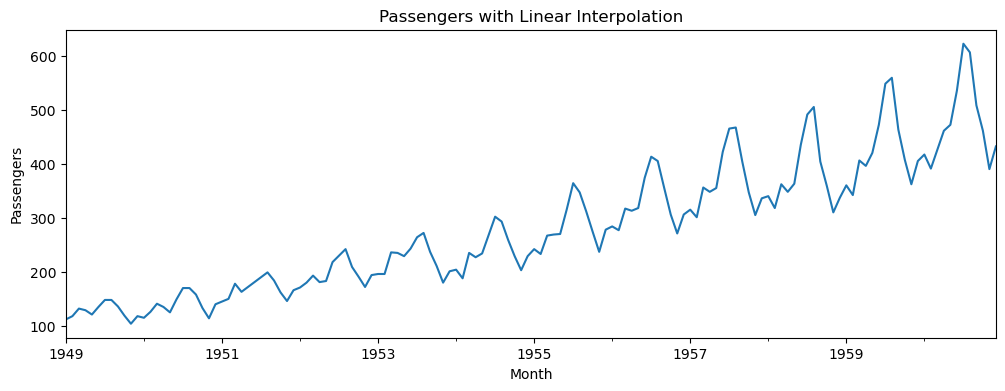

In [115]:
data["Passengers_Linear_Interpolation"] = data["Passengers"].interpolate(method="linear")
data["Passengers_Linear_Interpolation"].plot(figsize=(12, 4))
plt.xlabel("Month")
plt.ylabel("Passengers")
plt.title("Passengers with Linear Interpolation")
plt.show()

Looks better, we will move ahead with linear interpolation only.

In [116]:
data.head()

,Passengers,Passengers_Mean_imputation,Passengers_Linear_Interpolation
Month,,,
1949-01-01,112.0,112.0,112.0
1949-02-01,118.0,118.0,118.0
1949-03-01,132.0,132.0,132.0
1949-04-01,129.0,129.0,129.0
1949-05-01,121.0,121.0,121.0


In [117]:
# Dropping Passengers_Mean_imputation and Passengers columns.
# Renaming Passengers_Linear_Interpolation column to Passengers column.
data = data.drop(columns = ['Passengers', 'Passengers_Mean_imputation'])
data = data.rename(columns={'Passengers_Linear_Interpolation' : 'Passengers'})
data.head()

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


In [118]:
data.shape

(144, 1)

## Handling outliers

Q1:  180.75
Q2:  267.5
Q3:  360.5
Quartile-range:  179.75


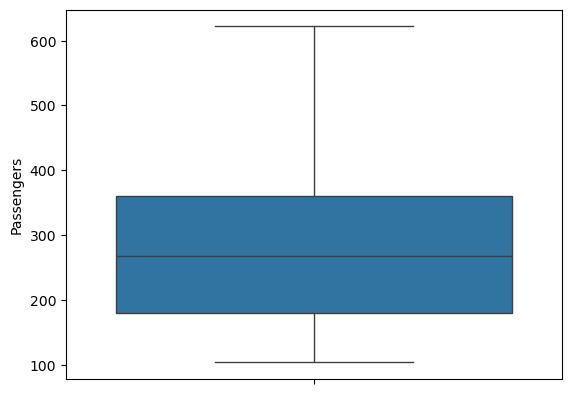

In [119]:
sns.boxplot(data['Passengers'])
print("Q1: ", data['Passengers'].quantile(0.25))
print("Q2: ", data['Passengers'].quantile(0.5))
print("Q3: ", data['Passengers'].quantile(0.75))
print("Quartile-range: ", data['Passengers'].quantile(0.75) - data['Passengers'].quantile(0.25))

No outliers detected.

# EDA

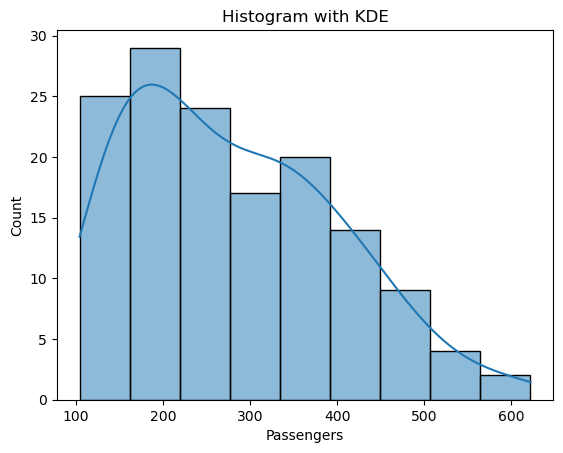

In [120]:
sns.histplot(data['Passengers'], kde=True)
plt.xlabel("Passengers")
plt.title("Histogram with KDE")
plt.show()

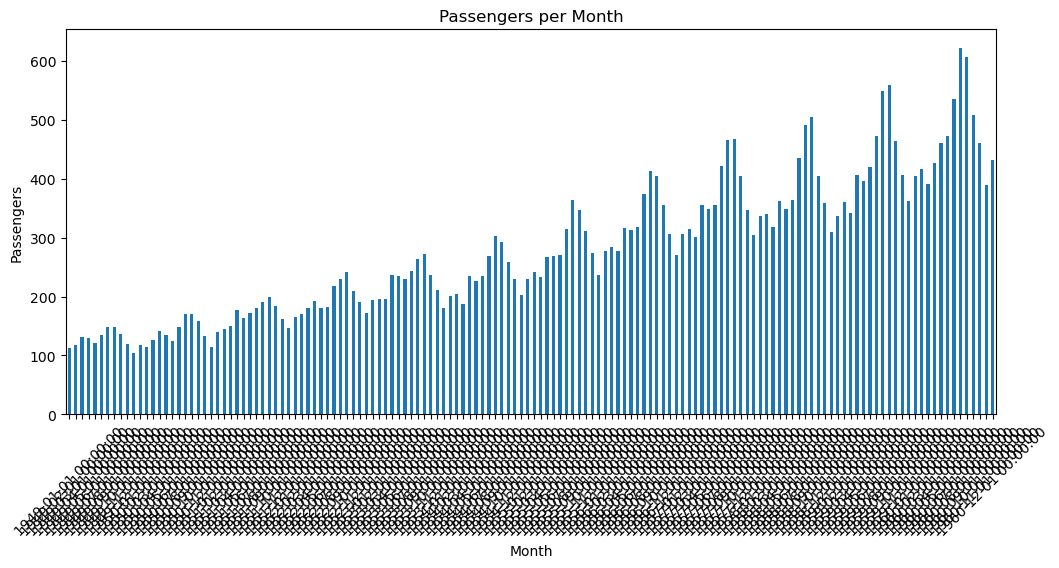

In [121]:
data['Passengers'].plot(kind='bar', figsize=(12, 5))
plt.xlabel("Month")
plt.ylabel("Passengers")
plt.title("Passengers per Month")
plt.xticks(rotation=45)
plt.show()

# Time Series Decomposition

## Multiplicative Seasonal Decomposition

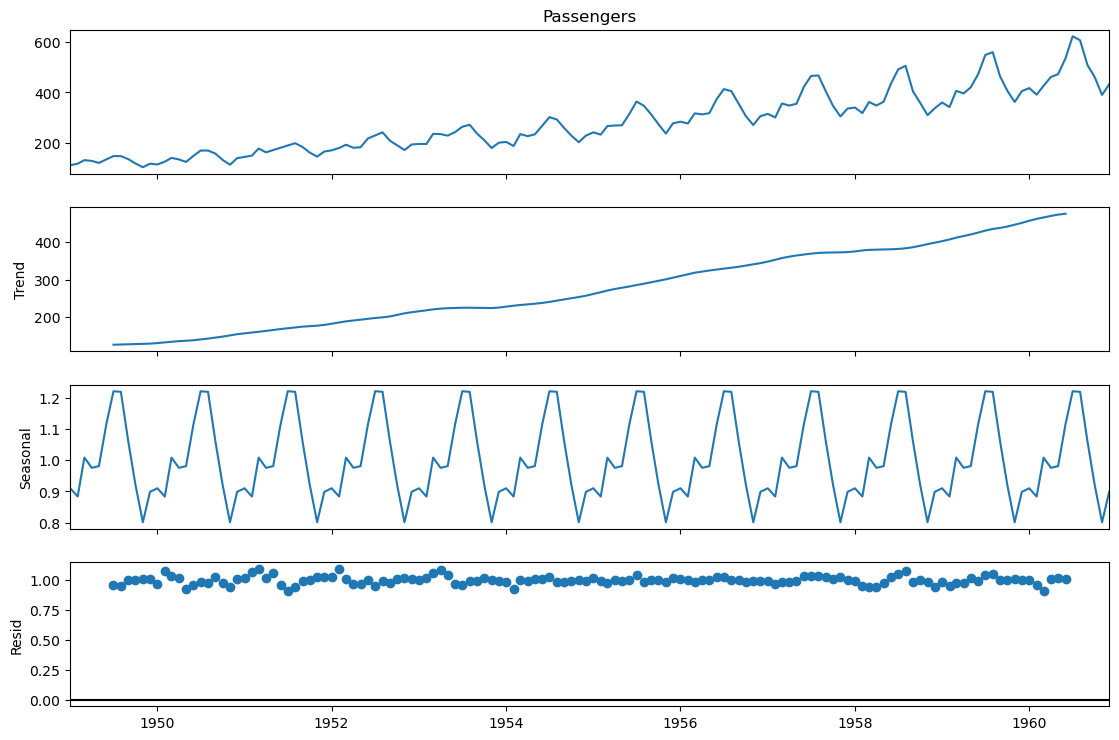

In [122]:
decomposition_mult = sm.tsa.seasonal_decompose(data['Passengers'], model='multiplicative')
fig = decomposition_mult.plot()
fig.set_size_inches(12, 8)  
plt.show()

# Time Series Forecasting

## Checking for stationarity

### 1. Visual Inspection

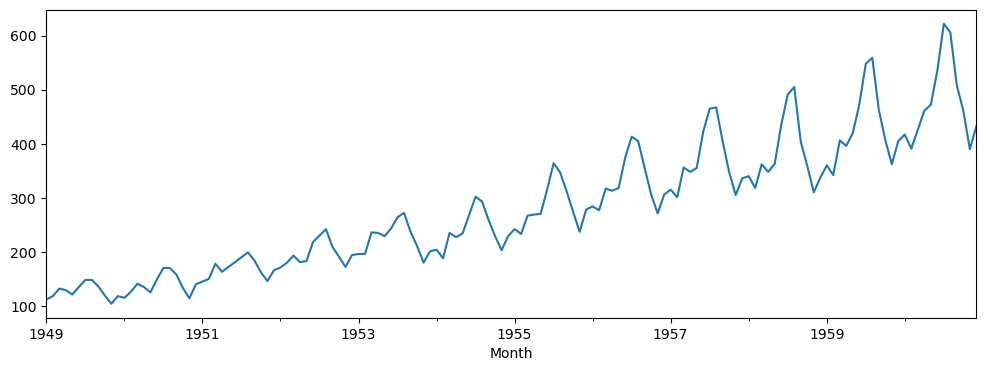

In [123]:
data["Passengers"].plot(figsize = (12,4))
plt.show()

1. There is an upward trend.(changing mean)
2. The spread of values is changing with time.(changing variance - Heteroscedasticity)
3. There are regular seasonal spikes( mean & variance are time dependent).

Hence, the time series is not stationary.
A non-stationary time series typically shows changing mean, changing variance, trend, seasonality, or persistent autocorrelation. That’s why we apply differencing, detrending, and seasonal adjustment to make it stationary before modeling.

### 2. Augmented Dickey-Fuller Test(ADF Test)
H0: The series is non-stationary.

H1: The series is stationary.

In [124]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(data['Passengers'])

print('ADF Statistic: %0.2f' % adf_test[0])
print('p-value: %0.2f' %adf_test[1])
print('Critical value at 5% level of significance:', adf_test[4]['5%'])

if adf_test[1] <= 0.05:
    print("Reject H0 → Stationary")
else:
    print("Fail to Reject H0 → Non-Stationary")

ADF Statistic: 0.89
p-value: 0.99
Critical value at 5% level of significance: -2.8840418343195267
Fail to Reject H0 → Non-Stationary


### 3. KPSS Test
H0: The series is stationary.

H1: The series is non-stationary.

In [125]:
from statsmodels.tsa.stattools import kpss

kpss_test = kpss(data['Passengers'])

print("KPSS Statistic:", kpss_test[0])
print("p-value:", kpss_test[1])
print("Critical Values:", kpss_test[3])

if kpss_test[1] <= 0.05:
    print("Reject H0 → Non-Stationary")
else:
    print("Fail to Reject H0 → Stationary")

KPSS Statistic: 1.6511897469421617
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Reject H0 → Non-Stationary


## Converting Non-stationary into Stationary Time Series
- If difference-stationary → apply differencing.
- If variance not constant → log / Box-Cox transform.
- If seasonality → seasonal adjustment or differencing.

After transformation, re-run ADF/KPSS to confirm stationarity.

- We can see the variance has become almost constant after the transformation.
- But we can see that the series still has an upward trend. So, the mean is not constant yet. Hence, we need to do Differencing to make the mean constant.

### Differencing
Differencing is performed by subtracting the previous observation from the current observation making the series stationary.
- Removes trend and seasonality from a time series. 
- Seasonality is removed (not by ordinary differencing) by seasonal differencing with lag equal to the cycle length.

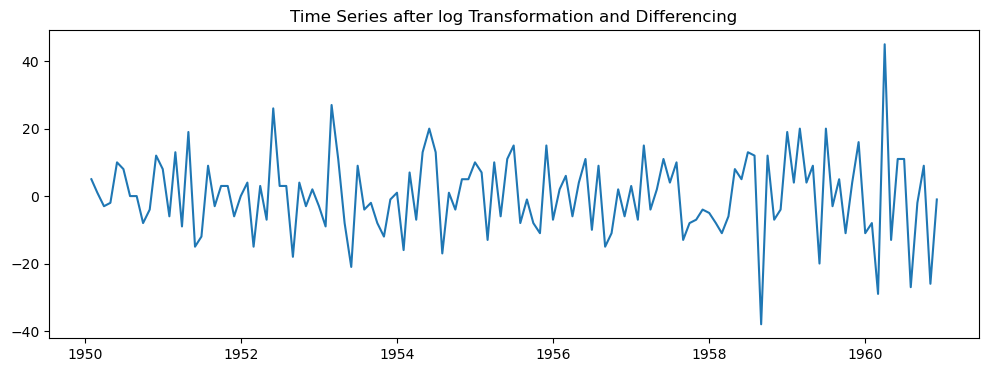

In [126]:
# First order differencing to remove trend
data_diff = pd.Series(data["Passengers"] - data["Passengers"].shift(), index=data.index)
# Dropping the first NaN (since first observation has no previous value)
data_diff.dropna(inplace=True)

# Seasonal differencing to remove seasonality
seasonal_diff = data_diff - data_diff .shift(12)
seasonal_diff.dropna(inplace=True)

# Plotting the Time series after Box Cox transformation and Differencing
plt.figure(figsize=(12,4))
plt.plot(seasonal_diff)
plt.title("Time Series after log Transformation and Differencing")
plt.show()

- No trend (upward or downward) after differencing. 
- The mean has become constant (zero).
- Also, the variance is almost constant.

Check again for stationarity.

In [127]:
adf_test_2 = adfuller(seasonal_diff)
print('ADF Statistic: %0.2f' % adf_test_2[0])
print('p-value: %0.2f' %adf_test_2[1])
print('Critical value at 5% level of significance:', adf_test_2[4]['5%'])

if adf_test_2[1] <= 0.05:
    print("Reject H0 → Stationary")
else:
    print("Fail to Reject H0 → Non-Stationary")

ADF Statistic: -14.69
p-value: 0.00
Critical value at 5% level of significance: -2.8840418343195267
Reject H0 → Stationary


## Making ACF and PACF plots

AR (AutoRegressive):
- PACF → cuts off after p lags (shows order of AR).
- ACF → decays slowly.

MA (Moving Average):
- ACF → cuts off after q lags.
- PACF → decays slowly.

ARMA:
- Both ACF & PACF decay slowly.

### 1. Auto Correlation Function (ACF) Plot
Autocorrelation refers to the correlation of a time series with its own lagged values.
- Shows correlation between current observation and its past lags.
- If a bar goes outside the confidence band, that lag is statistically significant.
- For seasonal data, big spikes appear at multiples of the seasonal period.

<Figure size 1600x400 with 0 Axes>

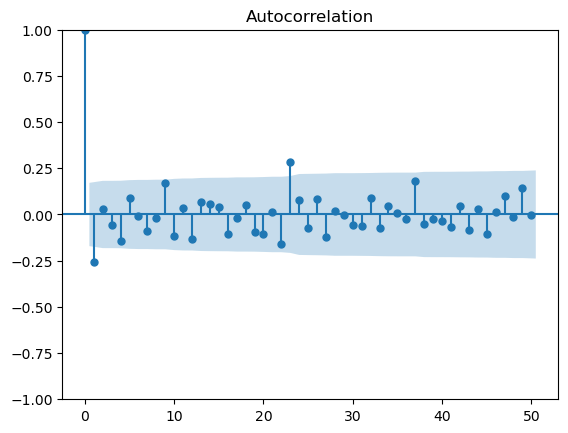

In [128]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(16,4))
plot_acf(seasonal_diff, lags=50)
plt.show()

1. The shaded portion is less significant.
2. Clear annual seasonality (period = 12 months).

### 2. Partial Auto Correlation Function (PACF) Plot
Partial Autocorrelation measures the direct relationship between a time series and its lagged value, after removing the effects of all shorter lags.
- Shows correlation at each lag after removing effects of earlier lags.
- Useful for identifying AR (Auto-Regressive) terms in ARIMA.
- If a bar goes outside the confidence band, that lag is statistically significant.

<Figure size 1600x400 with 0 Axes>

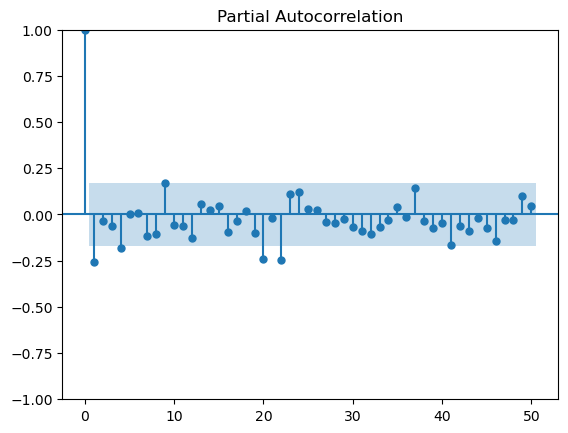

In [129]:
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(16,4))
plot_pacf(seasonal_diff, lags=50)
plt.show()

Little change in the correlation plot. Because PACF only captures the direct correlation with the time lag. It bypasses the tile lags in between.

From the above ACF & PACF plots, the possible values of p,q and P,Q are:

p = 0,1,4,9<br>
q = 1<br>
P = 1,2<br>
Q = 1,2,3

# Train-test split

In [ ]:
data= pd.Series(np.log(data['Passengers']), index=data.index)

In [130]:
train = data[:108]
test = data[108:]

## Model Fitting

In [131]:
orders = [(0,1,1), (1,1,1), (4,1,1), (9,1,1)]
seasonal_orders = [(1,1,1,12), (1,1,2,12), (1,1,3,12), (2,1,1,12), (2,1,2,12), (2,1,3,12)]

In [132]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Initialize best trackers
best_rmse = float('inf')
best_mape = float('inf')

best_model_rmse = None
best_model_mape = None

best_order_rmse = None
best_order_mape = None

best_seasonal_order_rmse = None
best_seasonal_order_mape = None

for order in orders:
    for seasonal_order in seasonal_orders:
        model = SARIMAX(train["Passengers"], order=order, seasonal_order=seasonal_order).fit()

        predicted = model.predict(start=test["Passengers"].index[0], end=test["Passengers"].index[-1])
        actual = test["Passengers"]
        rmse = ((actual - predicted)**2).mean()**0.5
        mape = (abs(actual - predicted)*100/actual).mean()
        print('{}{}: AIC = {}, BIC = {}, LLF = {}, MAPE = {}, RMSE = {}'.format(
            order, seasonal_order, model.aic, model.bic, model.llf, mape, rmse))

        # Track best by RMSE
        if rmse < best_rmse:
            best_rmse = rmse
            best_model_rmse = model
            best_order_rmse = order
            best_seasonal_order_rmse = seasonal_order

        # Track best by MAPE
        if mape < best_mape:
            best_mape = mape
            best_model_mape = model
            best_order_mape = order
            best_seasonal_order_mape = seasonal_order

# Print all best models
print("\nBest model by RMSE:")
print("Order:", best_order_rmse)
print("Seasonal order:", best_seasonal_order_rmse)
print("RMSE:", best_rmse)

print("\nBest model by MAPE:")
print("Order:", best_order_mape)
print("Seasonal order:", best_seasonal_order_mape)
print("MAPE:", best_mape)


(0, 1, 1)(1, 1, 1, 12): AIC = 706.0672999407498, BIC = 716.2828075071519, LLF = -349.0336499703749, MAPE = 4.092113980274354, RMSE = 22.684423245141218
(0, 1, 1)(1, 1, 2, 12): AIC = 701.8386142540378, BIC = 714.6079987120405, LLF = -345.9193071270189, MAPE = 4.402961347579469, RMSE = 20.480648613992443
(0, 1, 1)(1, 1, 3, 12): AIC = 703.5946742154708, BIC = 718.9179355650741, LLF = -345.7973371077354, MAPE = 4.615390547333298, RMSE = 21.07216539140213
(0, 1, 1)(2, 1, 1, 12): AIC = 702.7059940910959, BIC = 715.4753785490987, LLF = -346.35299704554797, MAPE = 4.118657606752983, RMSE = 19.417321248629978
(0, 1, 1)(2, 1, 2, 12): AIC = 703.3468059362291, BIC = 718.6700672858324, LLF = -345.67340296811454, MAPE = 4.743555142383464, RMSE = 21.42737617171088
(0, 1, 1)(2, 1, 3, 12): AIC = 705.6689857515987, BIC = 723.5461239928024, LLF = -345.83449287579936, MAPE = 4.487577600530976, RMSE = 20.749163263110315
(1, 1, 1)(1, 1, 1, 12): AIC = 703.5466356592839, BIC = 716.3160201172866, LLF = -346.77

In [133]:
final_model = SARIMAX(train, order = (0,1,1), seasonal_order=(1, 1, 1, 12)).fit()
print(final_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         Passengers   No. Observations:                  108
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -349.034
Date:                            Tue, 02 Sep 2025   AIC                            706.067
Time:                                    14:51:53   BIC                            716.283
Sample:                                01-01-1949   HQIC                           710.195
                                     - 12-01-1957                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1724      0.099     -1.743      0.081      -0.366       0.021
ar.S.L12      -0.4113      0.573   

## Residual Analysis
The residuals are independent and follow Normal distribution with mean 0.

<Axes: title={'center': 'Density of residuals'}, ylabel='Density'>

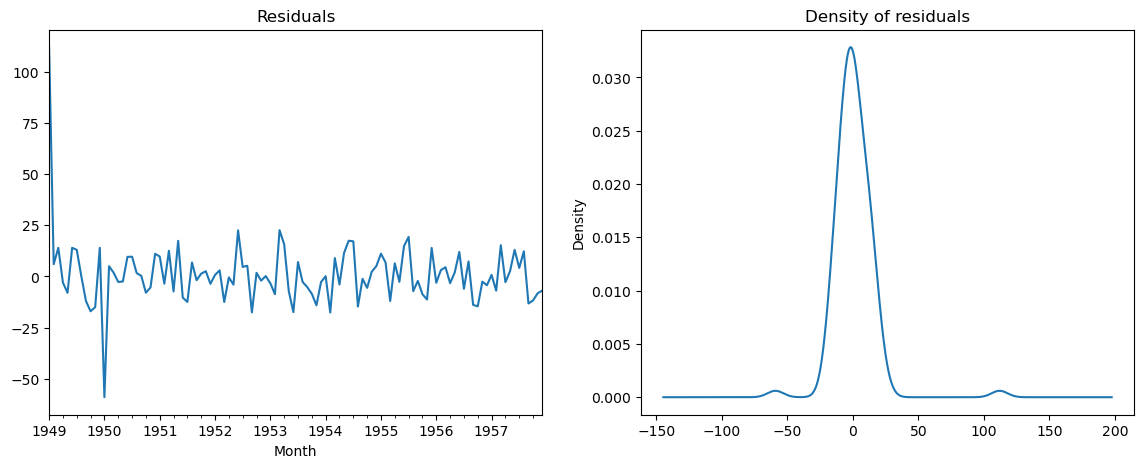

In [134]:
#res = data["Passengers"] - np.exp(final_model.predict(start = data.index[0], end = data.index[-1]))
res = final_model.resid
fig, ax = plt.subplots(1,2,figsize = (14,5))
res.plot(title = 'Residuals', ax = ax[0])
res.plot(title = 'Density of residuals', kind = 'kde', ax = ax[1])

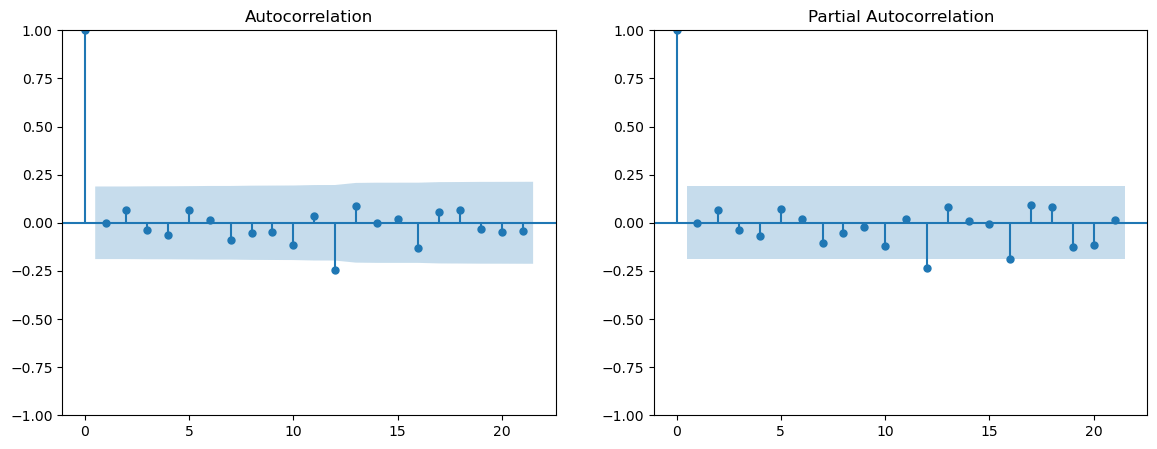

In [135]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14,5))
res_acf = plot_acf(res, ax = ax[0])
res_pacf = plot_pacf(res, ax = ax[1])

## Forecasting

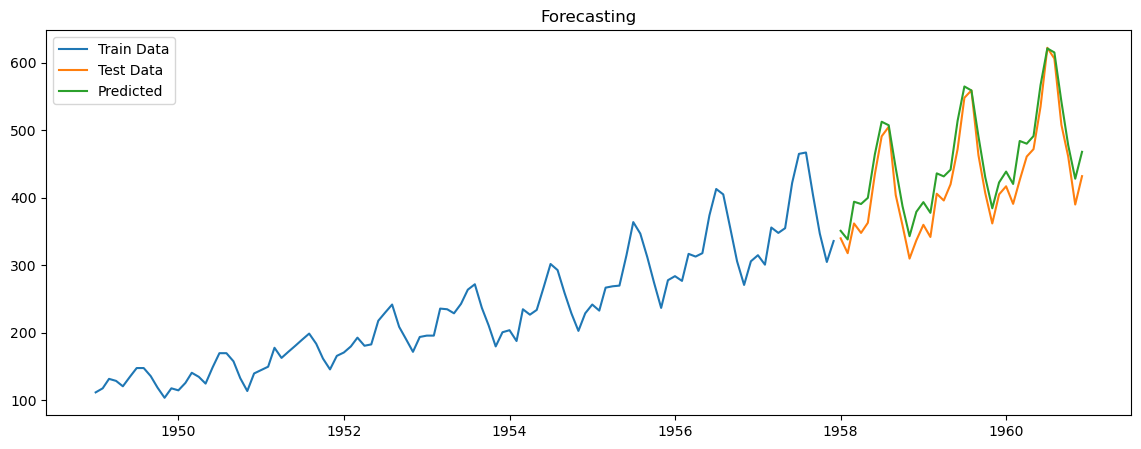

In [ ]:
fig = plt.subplots(figsize = (14,5))

plt.plot(np.exp(train), label = 'Train Data')
plt.plot(np.exp(test), label = 'Test Data')
plt.plot(np.exp(model.forecast(steps = 36)), label = 'Predicted')
plt.title('Forecasting')
plt.legend()
plt.show()